In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import sklearn
from sklearn.model_selection import train_test_split


### Train-Test Split

In [103]:
data = pd.read_csv('train.csv')

X = data.drop(columns=['hazardous'])
Y = data['hazardous']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    Y, 
    test_size=0.2, 
    random_state=42,
    stratify=Y
)

print(X.shape,Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4034, 23) (4034,)
(3227, 23) (3227,)
(807, 23) (807,)


In [104]:
def print_missing(data):
    missing_counts_4 = data.isnull().sum()
    missing_percentage_4 = (data.isnull().mean() * 100)

    # Combine into a summary table for easy viewing
    missing_summary_4 = pd.DataFrame({
        'Missing Count': missing_counts_4,
        'Percentage (%)': missing_percentage_4,
        'dtype': data.dtypes
    }).sort_values(by='Percentage (%)', ascending=False)

    print(missing_summary_4)

    return 0

In [105]:
print(X_train['jupiter_tisserand_invariant'])

1321    5.990
3562    4.311
2331    6.086
564     6.927
2928    4.881
        ...  
3546      NaN
1958      NaN
224       NaN
781       NaN
3359      NaN
Name: jupiter_tisserand_invariant, Length: 3227, dtype: float64


### Getting to know the data better 

In [106]:
#Provides a concise summary, including the number of entries, column names, and data types
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3227 entries, 1321 to 3359
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          3227 non-null   int64  
 1   epoch_date_close_approach     2342 non-null   float64
 2   relative_velocity_km_per_sec  2284 non-null   object 
 3   relative_velocity_km_per_hr   2148 non-null   float64
 4   miles_per_hour                2629 non-null   float64
 5   miss_dist_astronomical        2794 non-null   float64
 6   miss_dist_lunar               2450 non-null   float64
 7   miss_dist_kilometers          2255 non-null   float64
 8   miss_dist_miles               2764 non-null   float64
 9   jupiter_tisserand_invariant   1991 non-null   float64
 10  epoch_osculation              2125 non-null   float64
 11  semi_major_axis               2384 non-null   float64
 12  asc_node_longitude            2459 non-null   float64
 13  perih

In [107]:
print("Let us look at percentage of missing values per column")
# 1. Identify and Quantify
missing_counts = X_train.isnull().sum()
missing_percentage = (X_train.isnull().mean() * 100)

# Combine into a summary table for easy viewing
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage (%)': missing_percentage,
    'dtype': X_train.dtypes
}).sort_values(by='Percentage (%)', ascending=False)

print(missing_summary)

Let us look at percentage of missing values per column
                              Missing Count  Percentage (%)    dtype
orbit_uncertainity                     1261       39.076542   object
jupiter_tisserand_invariant            1236       38.301828  float64
epoch_osculation                       1102       34.149365  float64
perihelion_time                        1090       33.777502  float64
approach_month                         1090       33.777502  float64
mean_motion                            1083       33.560583  float64
relative_velocity_km_per_hr            1079       33.436628  float64
miss_dist_kilometers                    972       30.120855  float64
relative_velocity_km_per_sec            943       29.222188   object
epoch_date_close_approach               885       27.424853  float64
semi_major_axis                         843       26.123334  float64
perihelion_arg                          803       24.883793  float64
miss_dist_lunar                         777     

1. also miss_dist_astronomical, miss_dist_miles, miss_dist_lunar, miss_dist_kilometers tell about same thing. I am planning to use ***miss_dist_astronomical*** bcz it is only 13.38% empty and otheres are too much empty. if needed i will conver this to other units.
2. miles_per_hour and relative_velocity_km_per_hr tell the same thing. I am planning to use ***miles_per_hour*** as it is only 19.826518% empty copmare to 32% of relative_velocity_km_per_hr. if needed i will conver this to other units
Now let us drop these columns. 

In [108]:
columns_to_drop_ = ['miss_dist_miles', 'miss_dist_kilometers', 'miss_dist_lunar', 'relative_velocity_km_per_hr' ]
X_train =  X_train.drop(columns = columns_to_drop_)
X_test =  X_test.drop(columns = columns_to_drop_)

missing_counts_1 = X_train.isnull().sum()
missing_percentage_1 = (X_train.isnull().mean() * 100)

# Combine into a summary table for easy viewing
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts_1,
    'Percentage (%)': missing_percentage_1,
    'dtype': X_train.dtypes
}).sort_values(by='Percentage (%)', ascending=False)

print(missing_summary)

                              Missing Count  Percentage (%)    dtype
orbit_uncertainity                     1261       39.076542   object
jupiter_tisserand_invariant            1236       38.301828  float64
epoch_osculation                       1102       34.149365  float64
approach_month                         1090       33.777502  float64
perihelion_time                        1090       33.777502  float64
mean_motion                            1083       33.560583  float64
relative_velocity_km_per_sec            943       29.222188   object
epoch_date_close_approach               885       27.424853  float64
semi_major_axis                         843       26.123334  float64
perihelion_arg                          803       24.883793  float64
asc_node_longitude                      768       23.799194  float64
mean_anomaly                            643       19.925628  float64
miles_per_hour                          598       18.531143  float64
approach_year                     

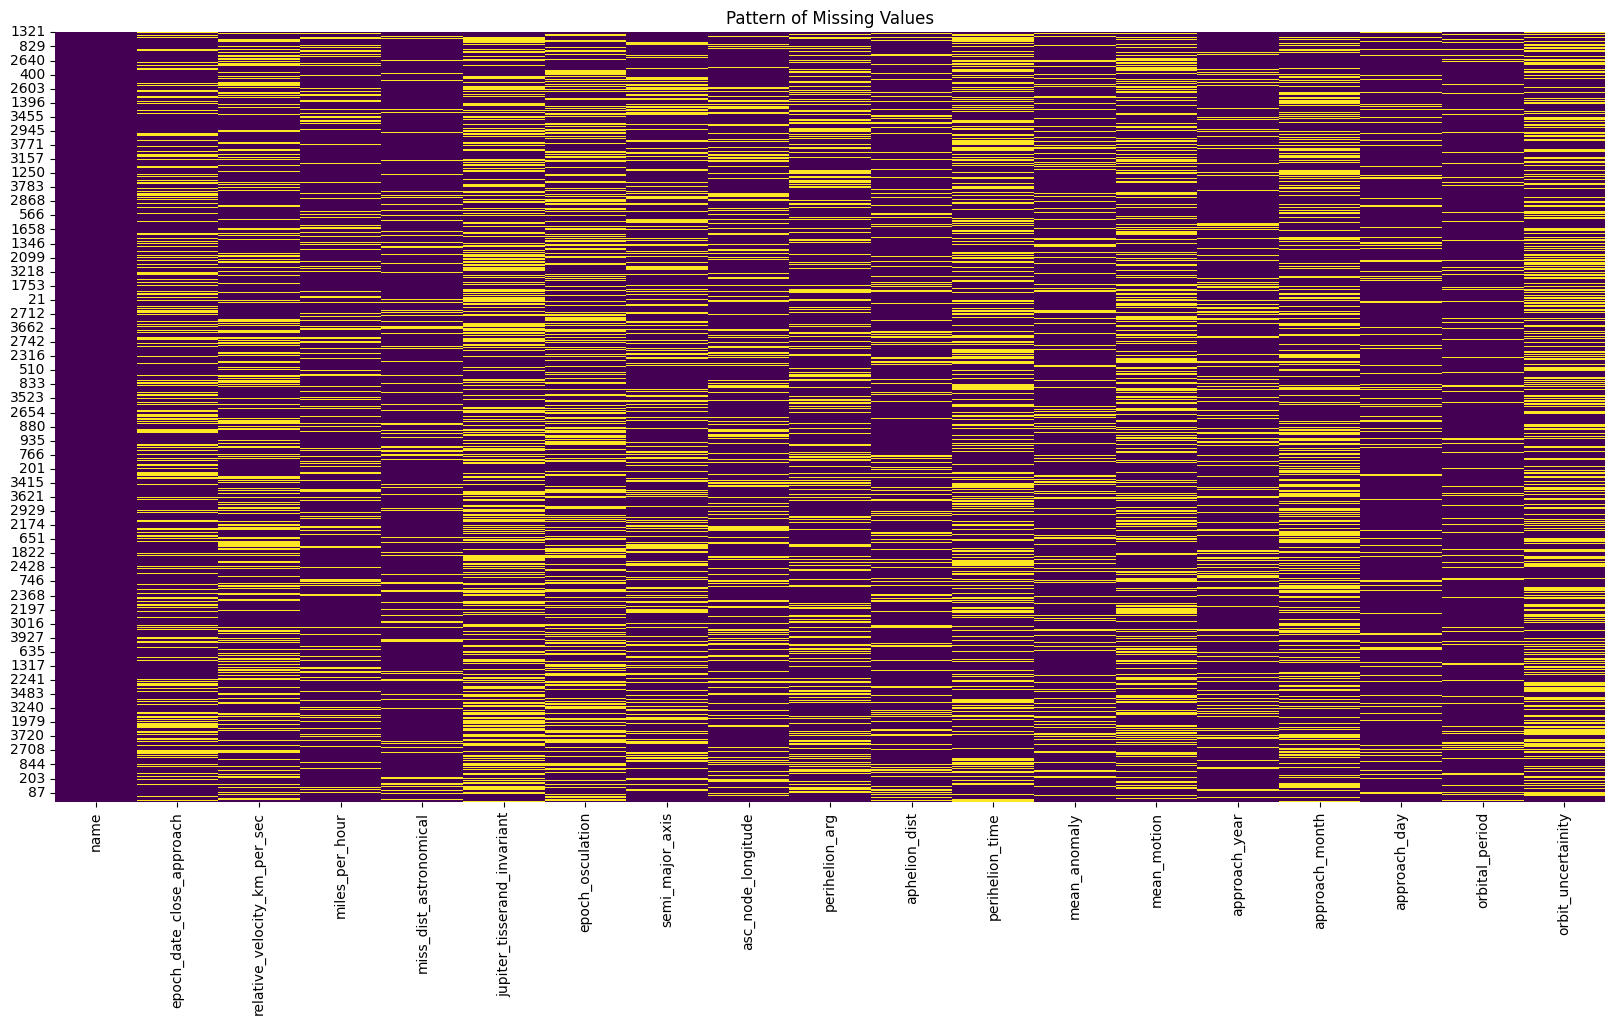

In [109]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.isnull(), cbar=False, cmap='viridis')
plt.title("Pattern of Missing Values")
plt.show()

Now we have to fill these empty values. 
1. Strong Physics Relationships 
- mean_motion ↔ semi_major_axis (Kepler's 3rd Law)
- aphelion_dist ↔ semi_major_axis + eccentricity
- jupiter_tisserand_invariant (from semi_major_axis + eccentricity)
2. Moderate Physics Relationships 
- Angular parameters (asc_node_longitude, perihelion_arg, mean_anomaly) - use circular statistics
- miss_dist_astronomical - might correlate with orbital characteristics
3. Temporal/Metadata 
- perihelion_time, epoch_osculation, epoch_date_close_approach - temporal relationships
- approach_year, approach_month, approach_day - observation metadata
4. Categorical 
- orbit_uncertainity
- orbital_period
- relative_velocity_km_per_sec - statistical methods


My stratergy to fill the Data: 
#### Physics-Based
1. Semi Major Axis - Mean Motion (Kepler's 3rd Law): If you have one, you can calculate the other exactly
2. Aphelion - Semi Major Axis - Eccentricity:
a = (aphelion + perihelion) / 2
e = (aphelion / a) - 1
3. Jupiter Tisserand Invariant:
J = (a_jupiter/a) + 2√(a/a_jupiter × (1-e²)) × cos(i)
we dont have inclination (i). We can assume i = 0 as most NEOs have low inclination. We can find this only if we have semi_major_axis + eccentricity. else we can use MICE

#### Angular Parameters (Circular Statistics) 
4. Asc Node Longitude, Perihelion Arg, Mean Anomaly:
- These are angular/cyclic variables
- Physics doesn't help much here - these vary widely for NEOs
- I am going to conver them to sin and cos and then drop the original columns and then use MICE

#### Temporal Metadata
5. Epoch Osculation, Perihelion Time, Epoch Date Close Approach:
- These are observation timestamps, not orbital properties

6. Approach Year/Month/Day:
- Pure metadata - when the asteroid was observed approaching Earth

#### Distance & Velocity (Independent Measurements)
7. Miss Distance (Astronomical)
- This is the closest approach distance - varies wildly between asteroids
- No physics formula to derive it from orbital elements alone
- MICE (correlates with velocity, orbital period)


8. Miles per Hour
- Relative velocity at closest approach
- Depends on both Earth's and asteroid's velocity vectors
- Can't derive from orbital elements alone (need trajectory)
- MICE (correlates with semi_major_axis, miss_distance)

#### Categorical Variables
9. Relative Velocity km per sec:
- i think if we have miles_per_hour, you can categorize it

10. Orbital Period
- Categorical version of the actual orbital period

11. Orbit Uncertainty
- No way to derive this
- New "Unknown" category as missing info might be usefull


In [110]:
AU = 1.496e11
G = 6.67430e-11
M_SUN = 1.989e30
MPH_to_KPS = 2236.94


def imputations(input_df):
    # 1. Properly copy the dataframe
    da = input_df.copy()

    # 2. Fill categorical missing values
    da['orbit_uncertainity'] = da['orbit_uncertainity'].fillna('Unknown')

    # --- Kepler's 3rd Law Imputations ---
    
    # Fill mean_motion
    m1 = da['mean_motion'].isna() & da['semi_major_axis'].notna()
    if m1.any():
        a_m = da.loc[m1, 'semi_major_axis'] * AU
        n_rad_per_sec = np.sqrt(G * M_SUN / a_m**3)
        da.loc[m1, 'mean_motion'] = n_rad_per_sec * (180/np.pi) * 86400
        print(f"Filled {m1.sum()} mean_motion from semi_major_axis")
    
    # Fill semi_major_axis
    m2 = da['semi_major_axis'].isna() & da['mean_motion'].notna()
    if m2.any():
        n_rad_per_sec = da.loc[m2, 'mean_motion'] * (np.pi/180) / 86400
        a_m = (G * M_SUN / n_rad_per_sec**2)**(1/3)
        da.loc[m2, 'semi_major_axis'] = a_m / AU
        print(f"Filled {m2.sum()} semi_major_axis from mean_motion")

    # --- Eccentricity and Aphelion ---

    m3 = da['aphelion_dist'].notna() & da['semi_major_axis'].notna()
    if m3.any():
        # Ensure column exists before calculation
        if 'eccentricity' not in da.columns:
            da['eccentricity'] = np.nan
        da.loc[m3, 'eccentricity'] = (da.loc[m3, 'aphelion_dist'] / 
                                      da.loc[m3, 'semi_major_axis']) - 1
        print(f"Calculated {m3.sum()} eccentricity values")
    
    if 'eccentricity' in da.columns:
        m4 = (da['aphelion_dist'].isna() & 
              da['semi_major_axis'].notna() & 
              da['eccentricity'].notna())
        if m4.any():
            da.loc[m4, 'aphelion_dist'] = (da.loc[m4, 'semi_major_axis'] * 
                                          (1 + da.loc[m4, 'eccentricity']))
            print(f"Filled {m4.sum()} aphelion_dist")
    
    cols_to_check = ['mean_motion', 'semi_major_axis', 'aphelion_dist', 'eccentricity']
    
    for col in cols_to_check:
        if col in da.columns:
            neg_mask = da[col] < 0
            count = neg_mask.sum()
            if count > 0:
                da.loc[neg_mask, col] = np.nan
                print(f"Set {count} negative values to NaN in {col}")

    return da

z = imputations(X_train)

print_missing(z)

Filled 792 mean_motion from semi_major_axis
Filled 552 semi_major_axis from mean_motion
Calculated 2402 eccentricity values
                              Missing Count  Percentage (%)    dtype
jupiter_tisserand_invariant            1236       38.301828  float64
epoch_osculation                       1102       34.149365  float64
approach_month                         1090       33.777502  float64
perihelion_time                        1090       33.777502  float64
relative_velocity_km_per_sec            943       29.222188   object
epoch_date_close_approach               885       27.424853  float64
eccentricity                            825       25.565541  float64
perihelion_arg                          803       24.883793  float64
asc_node_longitude                      768       23.799194  float64
mean_anomaly                            643       19.925628  float64
miles_per_hour                          598       18.531143  float64
approach_year                           589     

0

In [124]:
# Check which specific combinations are missing
missing_combinations = z[['epoch_date_close_approach', 'approach_month', 
                           'approach_day', 'approach_year', 'epoch_osculation']].isna()

# Get the most common patterns
pattern_counts = missing_combinations.value_counts()
print(pattern_counts)

epoch_date_close_approach  approach_month  approach_day  approach_year  epoch_osculation
False                      False           False         False          False               1821
                                                                        True                 936
True                       True            False         False          False                138
                                                                        True                  83
                           False           False         True           False                 55
                                           True          False          False                 42
                           True            False         True           False                 32
                                           True          False          False                 24
                           False           False         True           True                  22
                           True       

I am going to drop *relative_velocity_km_per_sec            943       29.222188   object*


In [ ]:
def fill_temporal_features_v2(da):
    da = da.copy()
    import pandas as pd
    
    # Strategy 1: Extract from timestamp wherever timestamp exists
    has_ts = da['epoch_date_close_approach'].notna()
    
    if has_ts.sum() > 0:
        # Convert all timestamps to datetime
        all_dates = pd.to_datetime(da['epoch_date_close_approach'], 
                                   unit='ms', errors='coerce')
        
        # Fill year
        da.loc[has_ts & da['approach_year'].isna(), 'approach_year'] = \
            all_dates[has_ts & da['approach_year'].isna()].dt.year
        
        # Fill month  
        da.loc[has_ts & da['approach_month'].isna(), 'approach_month'] = \
            all_dates[has_ts & da['approach_month'].isna()].dt.month
        
        # Fill day
        da.loc[has_ts & da['approach_day'].isna(), 'approach_day'] = \
            all_dates[has_ts & da['approach_day'].isna()].dt.day
        
        print(f"Extracted components from {has_ts.sum()} timestamps")
    
    # Strategy 2: Create timestamp from components
    has_components = (da['approach_year'].notna() & 
                     da['approach_month'].notna() & 
                     da['approach_day'].notna())
    needs_ts = da['epoch_date_close_approach'].isna() & has_components
    
    if needs_ts.sum() > 0:
        # Build datetime
        temp_df = pd.DataFrame({
            'year': da.loc[needs_ts, 'approach_year'].astype(int),
            'month': da.loc[needs_ts, 'approach_month'].astype(int),
            'day': da.loc[needs_ts, 'approach_day'].astype(int)
        })
        
        new_dates = pd.to_datetime(temp_df, errors='coerce')
        da.loc[needs_ts, 'epoch_date_close_approach'] = new_dates.astype(int) / 10**6
        
        print(f"Created {needs_ts.sum()} timestamps from components")
    
    return da

z = fill_temporal_features_v2(z)
print_missing(z)

Extracted components from 2342 timestamps
Created 415 timestamps from components
                              Missing Count  Percentage (%)    dtype
jupiter_tisserand_invariant            1236       38.301828  float64
epoch_osculation                       1102       34.149365  float64
perihelion_time                        1090       33.777502  float64
relative_velocity_km_per_sec            943       29.222188   object
eccentricity                            825       25.565541  float64
perihelion_arg                          803       24.883793  float64
asc_node_longitude                      768       23.799194  float64
mean_anomaly                            643       19.925628  float64
miles_per_hour                          598       18.531143  float64
aphelion_dist                           586       18.159281  float64
epoch_date_close_approach               470       14.564611  float64
miss_dist_astronomical                  433       13.418035  float64
orbital_period        

0

In [127]:
def simple_temporal_imputation(da):
    """
    Fill remaining temporal features with simple statistical imputation.
    
    Strategy:
    - approach_month: mode (most common month)
    - approach_day: median (middle of month ≈ 15)
    - approach_year: median (central tendency)
    - epoch_osculation: median (reference date)
    """
    da = da.copy()
    
    # Fill approach_month with mode
    if da['approach_month'].isna().sum() > 0:
        month_mode = da['approach_month'].mode()[0]
        count_before = da['approach_month'].isna().sum()
        da['approach_month'] = da['approach_month'].fillna(month_mode)
        print(f"✓ Filled {count_before} approach_month values with mode: {int(month_mode)}")
    
    # Fill approach_day with median
    if da['approach_day'].isna().sum() > 0:
        day_median = da['approach_day'].median()
        count_before = da['approach_day'].isna().sum()
        da['approach_day'] = da['approach_day'].fillna(day_median)
        print(f"✓ Filled {count_before} approach_day values with median: {int(day_median)}")
    
    # Fill approach_year with median
    if da['approach_year'].isna().sum() > 0:
        year_median = da['approach_year'].median()
        count_before = da['approach_year'].isna().sum()
        da['approach_year'] = da['approach_year'].fillna(year_median)
        print(f"✓ Filled {count_before} approach_year values with median: {int(year_median)}")
    
    # Fill epoch_osculation with median
    if da['epoch_osculation'].isna().sum() > 0:
        osculation_median = da['epoch_osculation'].median()
        count_before = da['epoch_osculation'].isna().sum()
        da['epoch_osculation'] = da['epoch_osculation'].fillna(osculation_median)
        print(f"✓ Filled {count_before} epoch_osculation values with median: {osculation_median:.2f}")
    
    print(f"\n✅ Temporal features imputation complete!")
    
    return da
def sync_timestamps_final(da):
    """
    Create timestamps for any remaining rows that have complete components.
    Call this AFTER simple_temporal_imputation.
    """
    da = da.copy()
    import pandas as pd
    
    # Find rows with components but missing timestamp
    has_components = (da['approach_year'].notna() & 
                     da['approach_month'].notna() & 
                     da['approach_day'].notna())
    needs_ts = da['epoch_date_close_approach'].isna() & has_components
    
    if needs_ts.sum() > 0:
        try:
            temp_df = pd.DataFrame({
                'year': da.loc[needs_ts, 'approach_year'].astype(int),
                'month': da.loc[needs_ts, 'approach_month'].astype(int),
                'day': da.loc[needs_ts, 'approach_day'].astype(int)
            })
            
            new_dates = pd.to_datetime(temp_df, errors='coerce')
            da.loc[needs_ts, 'epoch_date_close_approach'] = new_dates.astype(int) / 10**6
            
            print(f"✓ Created {needs_ts.sum()} timestamps from imputed components")
        except Exception as e:
            print(f"⚠ Warning: Could not create some timestamps - {e}")
    
    return da

# After your cross-filling
z_v3 = simple_temporal_imputation(z)

# Verify all temporal features are filled
temporal_cols = ['approach_month', 'approach_day', 'approach_year', 
                 'epoch_osculation', 'epoch_date_close_approach']
print("\nRemaining missing in temporal features:")
print(z_v3[temporal_cols].isna().sum())

✓ Filled 316 approach_month values with mode: 2
✓ Filled 120 approach_day values with median: 15
✓ Filled 153 approach_year values with median: 2008
✓ Filled 1102 epoch_osculation values with median: 2458000.50

✅ Temporal features imputation complete!

Remaining missing in temporal features:
approach_month                 0
approach_day                   0
approach_year                  0
epoch_osculation               0
epoch_date_close_approach    470
dtype: int64


In [128]:
def fill_remaining_timestamps(da):
    """
    Fill any remaining epoch_date_close_approach with median.
    Use this as a fallback if sync_timestamps_final doesn't catch everything.
    """
    da = da.copy()
    
    if da['epoch_date_close_approach'].isna().sum() > 0:
        ts_median = da['epoch_date_close_approach'].median()
        count_before = da['epoch_date_close_approach'].isna().sum()
        da['epoch_date_close_approach'] = da['epoch_date_close_approach'].fillna(ts_median)
        print(f"✓ Filled {count_before} epoch_date_close_approach values with median: {ts_median:.2f}")
    
    return da

# Use it:
z_v4 = sync_timestamps_final(z_v3)  # Try creating from components first
z_v4 = fill_remaining_timestamps(z_v4)  # Fill any stragglers with median

# Final verification
print("\n" + "="*60)
print("🎯 FINAL TEMPORAL FEATURES STATUS")
print("="*60)
print(z_v4[['epoch_date_close_approach', 'approach_month', 
            'approach_day', 'approach_year', 'epoch_osculation']].isna().sum())
print("\n✅ Should be all zeros!")

✓ Created 470 timestamps from imputed components

🎯 FINAL TEMPORAL FEATURES STATUS
epoch_date_close_approach    0
approach_month               0
approach_day                 0
approach_year                0
epoch_osculation             0
dtype: int64

✅ Should be all zeros!


In [129]:
print_missing(z_v4)

                              Missing Count  Percentage (%)    dtype
jupiter_tisserand_invariant            1236       38.301828  float64
perihelion_time                        1090       33.777502  float64
relative_velocity_km_per_sec            943       29.222188   object
eccentricity                            825       25.565541  float64
perihelion_arg                          803       24.883793  float64
asc_node_longitude                      768       23.799194  float64
mean_anomaly                            643       19.925628  float64
miles_per_hour                          598       18.531143  float64
aphelion_dist                           586       18.159281  float64
miss_dist_astronomical                  433       13.418035  float64
orbital_period                          381       11.806632   object
semi_major_axis                         291        9.017663  float64
mean_motion                             291        9.017663  float64
epoch_date_close_approach         

0

In [130]:
X_train = X_train.drop(columns = 'relative_velocity_km_per_sec')


KeyError: "['relative_velocity_km_per_sec'] not found in axis"

also
1. related 1 
orbital_period                         381       11.806632   object
mean_motion                            291        9.017663  float64
2. 

In [114]:
def convert_angles_to_circular(df):
    """Convert angular features to sin/cos representation"""
    angular_cols = ['asc_node_longitude', 'perihelion_arg', 'mean_anomaly']
    
    for col in angular_cols:
        if col in df.columns:
            radians = np.deg2rad(df[col])
            df[f'{col}_sin'] = np.sin(radians)
            df[f'{col}_cos'] = np.cos(radians)
    
    # Drop original degree columns
    df = df.drop(columns=[c for c in angular_cols if c in df.columns])
    
    return df

In [115]:
# Constants
AU = 1.496e11
G = 6.67430e-11
M_SUN = 1.989e30

# Calculate what mean_motion SHOULD be
a_m = X_train_final['semi_major_axis'] * AU
n_calculated = np.sqrt(G * M_SUN / a_m**3) * (180/np.pi) * 86400
n_actual = X_train_final['mean_motion']

# Calculate error
relative_error = np.abs(n_calculated - n_actual) / n_actual * 100

# Find the worst offenders
worst_indices = relative_error.nlargest(10).index

print("Top 10 asteroids violating Kepler's 3rd Law:")
print("="*80)
suspect_df = pd.DataFrame({
    'semi_major_axis': X_train_final.loc[worst_indices, 'semi_major_axis'],
    'mean_motion_actual': n_actual.loc[worst_indices],
    'mean_motion_expected': n_calculated.loc[worst_indices],
    'error_%': relative_error.loc[worst_indices]
})
print(suspect_df)

# Check if these were imputed or original
print("\nWere these values imputed by MICE?")
print("(Check if they had missing semi_major_axis or mean_motion originally)")

# Distribution of errors
print("\nError distribution:")
print(f"< 5% error: {(relative_error < 5).sum()} asteroids ({(relative_error < 5).sum()/len(relative_error)*100:.1f}%)")
print(f"5-10% error: {((relative_error >= 5) & (relative_error < 10)).sum()} asteroids")
print(f"10-20% error: {((relative_error >= 10) & (relative_error < 20)).sum()} asteroids")
print(f"> 20% error: {(relative_error >= 20).sum()} asteroids ({(relative_error >= 20).sum()/len(relative_error)*100:.1f}%)")

Top 10 asteroids violating Kepler's 3rd Law:
   semi_major_axis  mean_motion_actual  mean_motion_expected  error_%
0         1.017582            0.960296              0.960296      0.0
1         0.972347            1.028081              1.028081      0.0
2         1.074304            0.885255              0.885255      0.0
3         0.944193            1.074405              1.074405      0.0
4         2.377535            0.268886              0.268886      0.0
5         1.431002            0.575836              0.575836      0.0
6         1.147613            0.801800              0.801800      0.0
7         0.851840            1.253783              1.253783      0.0
8         1.552813            0.509425              0.509425      0.0
9         1.337563            0.637218              0.637218      0.0

Were these values imputed by MICE?
(Check if they had missing semi_major_axis or mean_motion originally)

Error distribution:
< 5% error: 3227 asteroids (100.0%)
5-10% error: 0 asteroi

In [116]:
# Check which asteroids originally had missing values
# (You'll need to run this on your ORIGINAL data before imputation)

# Load original data again
data_original = pd.read_csv('train.csv')
X_original = data_original.drop(columns=['hazardous'])

X_train_original, _, _, _ = train_test_split(
    X_original, data_original['hazardous'], 
    test_size=0.2, 
    random_state=42,
    stratify=data_original['hazardous']
)

# Check the problem indices
problem_indices = [2104, 1609, 391, 466, 102, 2819, 2587, 2559, 2879]

print("Did these asteroids have missing values originally?")
print("="*80)
for idx in problem_indices:
    sma_missing = pd.isna(X_train_original.loc[idx, 'semi_major_axis'])
    mm_missing = pd.isna(X_train_original.loc[idx, 'mean_motion'])
    print(f"Index {idx}: semi_major_axis missing={sma_missing}, mean_motion missing={mm_missing}")

Did these asteroids have missing values originally?
Index 2104: semi_major_axis missing=False, mean_motion missing=False
Index 1609: semi_major_axis missing=True, mean_motion missing=False
Index 391: semi_major_axis missing=False, mean_motion missing=False
Index 466: semi_major_axis missing=True, mean_motion missing=False
Index 102: semi_major_axis missing=False, mean_motion missing=False
Index 2819: semi_major_axis missing=False, mean_motion missing=True
Index 2587: semi_major_axis missing=True, mean_motion missing=False
Index 2559: semi_major_axis missing=False, mean_motion missing=True
Index 2879: semi_major_axis missing=False, mean_motion missing=True


In [117]:

# ============================================
# STEP 1: CREATE VIOLATION FEATURE (OPTIONAL)
# ============================================

def add_kepler_violation_feature(df):
    """
    Capture magnitude of Kepler's law violation
    This might indicate measurement uncertainty
    """
    df = df.copy()
    
    AU = 1.496e11
    G = 6.67430e-11
    M_SUN = 1.989e30
    
    a_m = df['semi_major_axis'] * AU
    n_expected = np.sqrt(G * M_SUN / a_m**3) * (180/np.pi) * 86400
    
    # Relative error as a feature
    df['kepler_violation'] = np.abs(
        df['mean_motion'] - n_expected
    ) / df['mean_motion']
    
    print(f"✓ Created kepler_violation feature")
    print(f"  Mean violation: {df['kepler_violation'].mean()*100:.2f}%")
    print(f"  Max violation: {df['kepler_violation'].max()*100:.2f}%")
    
    return df

X_train_final = add_kepler_violation_feature(X_train_final)
X_test_final = add_kepler_violation_feature(X_test_final)

# ============================================
# STEP 2: ENFORCE KEPLER'S LAW
# ============================================

def enforce_keplers_law(df):
    """
    Recalculate mean_motion from semi_major_axis
    """
    df = df.copy()
    
    AU = 1.496e11
    G = 6.67430e-11
    M_SUN = 1.989e30
    
    a_m = df['semi_major_axis'] * AU
    df['mean_motion'] = np.sqrt(G * M_SUN / a_m**3) * (180/np.pi) * 86400
    
    return df

X_train_final = enforce_keplers_law(X_train_final)
X_test_final = enforce_keplers_law(X_test_final)

print("\n✓ Physics enforced: Kepler's 3rd Law now holds")

# ============================================
# STEP 3: VALIDATE
# ============================================

# Should now be perfect
a_m = X_train_final['semi_major_axis'] * AU
n_calc = np.sqrt(G * M_SUN / a_m**3) * (180/np.pi) * 86400
error = np.abs(n_calc - X_train_final['mean_motion']) / X_train_final['mean_motion'] * 100

print(f"\nValidation:")
print(f"  Mean error: {error.mean():.2e}%")  # Should be ~0
print(f"  Max error: {error.max():.2e}%")    # Should be ~0


✓ Created kepler_violation feature
  Mean violation: 0.00%
  Max violation: 0.00%
✓ Created kepler_violation feature
  Mean violation: 0.00%
  Max violation: 0.00%

✓ Physics enforced: Kepler's 3rd Law now holds

Validation:
  Mean error: 0.00e+00%
  Max error: 0.00e+00%


In [118]:
print(X_train_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   name                          3227 non-null   int64   
 1   epoch_date_close_approach     3227 non-null   float64 
 2   relative_velocity_km_per_sec  3227 non-null   category
 3   miles_per_hour                3227 non-null   float64 
 4   miss_dist_astronomical        3227 non-null   float64 
 5   jupiter_tisserand_invariant   3227 non-null   float64 
 6   epoch_osculation              3227 non-null   float64 
 7   semi_major_axis               3227 non-null   float64 
 8   aphelion_dist                 3227 non-null   float64 
 9   perihelion_time               3227 non-null   float64 
 10  mean_motion                   3227 non-null   float64 
 11  approach_year                 3227 non-null   float64 
 12  approach_month                3227 non-null   fl

3227
Series([], Name: kepler_violation, dtype: float64)


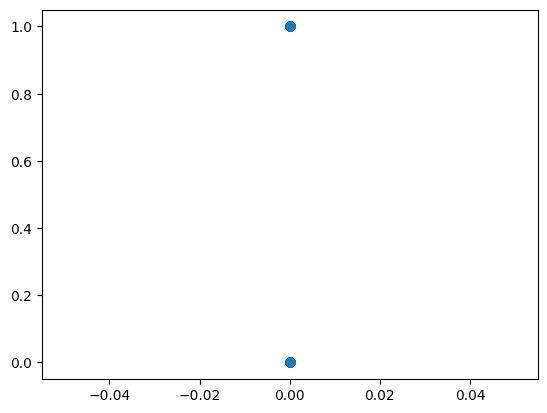

In [119]:

# Quick visual check: Do hazardous asteroids have different orbital energies?
mask_ = X_train_final['kepler_violation'] * 100 > 10
X_train_final.loc[mask_, 'kepler_violation'] * 100
violations = X_train_final.loc[
    X_train_final['kepler_violation'] * 100 > 1,
    'kepler_violation'
] * 100
print(len(X_train_final))
print(violations)

plt.scatter(X_train_final['kepler_violation'], y_train)
plt.show()


In [120]:
missing_counts_2 = X_train_final.isnull().sum()
missing_percentage_2 = (X_train_final.isnull().mean() * 100)

# Combine into a summary table for easy viewing
missing_summary_2 = pd.DataFrame({
    'Missing Count': missing_counts_2,
    'Percentage (%)': missing_percentage_2,
    'dtype': X_train_final.dtypes
}).sort_values(by='Percentage (%)', ascending=False)

print(missing_summary_2)

                              Missing Count  Percentage (%)     dtype
name                                      0             0.0     int64
epoch_date_close_approach                 0             0.0   float64
relative_velocity_km_per_sec              0             0.0  category
miles_per_hour                            0             0.0   float64
miss_dist_astronomical                    0             0.0   float64
jupiter_tisserand_invariant               0             0.0   float64
epoch_osculation                          0             0.0   float64
semi_major_axis                           0             0.0   float64
aphelion_dist                             0             0.0   float64
perihelion_time                           0             0.0   float64
mean_motion                               0             0.0   float64
approach_year                             0             0.0   float64
approach_month                            0             0.0   float64
approach_day        

In [121]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True)*100)

hazardous
0    2878
1     349
Name: count, dtype: int64
hazardous
0    89.185002
1    10.814998
Name: proportion, dtype: float64


In [122]:
print(y_test.value_counts())
print(y_test.value_counts(normalize=True)*100)

hazardous
0    720
1     87
Name: count, dtype: int64
hazardous
0    89.219331
1    10.780669
Name: proportion, dtype: float64


Let us first divide our data

In [123]:
columns_to_drop = ['relative_velocity_km_per_sec', 'orbit_uncertainity', 'orbital_period']
X_train_num =  X_train.drop(columns = columns_to_drop)
X_train_obj = X_train.select_dtypes(include=['object'])
X_test_num =  X_test.drop(columns = columns_to_drop)
X_test_obj = X_test.select_dtypes(include=['object'])
print("only data with numbers")
print(X_train_num.info())
print("only data with objects")
print(X_train_obj.info())

KeyError: "['relative_velocity_km_per_sec'] not found in axis"

Now let us also look at skewness of the data

In [ ]:
skewness_vals = X_train_num.skew().sort_values(ascending=False)

# Flag features that need transformation (> 0.5 or < -0.5)
transform_needed = skewness_vals
print("output of the .skew")
print(transform_needed)

output of the .skew
aphelion_dist                  1.141254
miles_per_hour                 0.944164
semi_major_axis                0.858601
mean_motion                    0.380057
jupiter_tisserand_invariant    0.161844
asc_node_longitude             0.079230
approach_day                   0.015815
name                          -0.021372
approach_month                -0.025935
perihelion_arg                -0.046545
mean_anomaly                  -0.081519
miss_dist_astronomical        -0.100611
approach_year                 -0.306103
epoch_date_close_approach     -0.311963
perihelion_time               -3.761042
epoch_osculation              -3.779342
dtype: float64
